Un nuevo comercio comenzó a funcionar en la ciudad e inicialmente cuenta con dos cajas que atienden continuamente la llegada de los clientes que desean pagar por los productos que compraron. 
Cada cajero tiene una tasa de atención diferente: El primero de ellos atiende cada cliente a un promedio de 15 minutos +/- 3 minutos siguiendo una distribución Normal mientras que segundo de ellos tiene una tasa de atención cuyo tiempo promedio es exponencial de 12 minutos por cada cliente. 
Durante la jornada, los clientes llegan en promedio cada 10 minutos siguiendo una distribución exponencial. 
Al comercio le interesa calcular el tiempo promedio que pasan los clientes esperando en la cola con el fin de determinar la necesidad de más cajas para minimizar la espera. 


In [197]:
import numpy as np
import seaborn as sb

In [198]:
def intervalo_confianza(lista):
    media = np.mean(lista)
    valor_z = 1.95 #para el 95%
    desvio = np.std(lista)
    n = len(lista)
    
    ext_inferior = media - (valor_z * (desvio/(n ** 0.5)))
    ext_superior = media + (valor_z * (desvio/(n ** 0.5)))
    return ext_inferior, ext_superior

In [200]:
class Cajero():
    def __init__(self, tipo):
        if tipo == 1:
            self.nombre = "Empleado tipo 1"
            self.tiempoAtencion = np.random.normal(15,3) #Normal de media 15 minutos y Desv.est. de 3 minutos.
        elif tipo == 2:
            self.nombre = "Empleado tipo 2"
            self.tiempoAtencion = np.random.exponential(12) #Exponencial con tiempo promedio de 12 minutos.
        elif tipo == 3:
            self.nombre = "Empleado tipo 3"
            self.tiempoAtencion = np.random.normal(14,6) # #Normal con media=14 y desv. est. de 6

In [201]:
class Cliente():
    def __init__(self, id_camion):
        self.id = id_camion
        self.tiempoLlegada = int(np.random.exponential(10))
        self.tiempoInicioAtencion = -1
        
    def __repr__(self):
        return f"id: {self.id} - hora llegada: {self.tiempoLlegada} - hora en que fue atendido: {self.tiempoInicioAtencion}"

In [202]:
class Caja():
    def __init__(self, tipo):
        self.tipo = tipo
        self.ocupada = False
        self.tiempoOcupacion = 0
        self.tiempoAtencion = Cajero(tipo).tiempoAtencion
        
    def marcarLibre(self):
        self.ocupada = False
    
    def marcarOcupada(self):
        self.ocupada = True
    
    def actualizarPorcentajeOcupacion(self, reloj):
        self.tiempoOcupacion = self.tiempoOcupacion + reloj

In [203]:
class Evento():
    """
    nombre = puede ser ARRIBO_CLIENTE,INICIO_ATENCION, FIN_ATENCION
    objeto = puede ser un Camion o un Surtidor
    duracion = duracion del evento
    """
    def __init__(self, _id, nombre, objeto, arribo, duracion):
        self.id = _id
        self.nombre = nombre
        self.arribo = arribo
        self.duracion = duracion
        self.tiempo_fin = arribo + duracion
        self.objeto = objeto
        
    def __repr__(self):
        return f"{self.id} - {self.nombre} - arribo: {self.arribo} - duracion: {self.duracion} - termina: {self.tiempo_fin}\n"
    
    
class EventoFinAtencion(Evento):
    def __init__(self, evento_inicio, **kwargs):
        super(EventoFinAtencion, self).__init__(**kwargs)
        self.evento_inicio = evento_inicio
    
    def __repr__(self):
        return f"{self.id} - {self.nombre} a {self.evento_inicio.id} - inicia: {self.arribo} - duracion: {self.duracion} - termina: {self.tiempo_fin}\n"

In [204]:
def hayCajaLibre(lista_cajas):
    return any(not caja.ocupada  for caja in lista_cajas)

In [205]:
def getCajaLibre(lista_cajas):
    for caja in lista_cajas:
        if (not caja.ocupada):
            return caja

In [206]:
def ordenarEventos(fel):
    fel.sort(key=lambda evento: evento.arribo)
    return fel

In [207]:
def removerEvento(fel, evento): #remueve el siguiente evento de la FEL
    if evento in fel:
        fel.remove(evento)
    return ordenarEventos(fel)

In [208]:
def agregarEvento(fel, evento): #agrega un nuevo evento y ordena la FEL
    fel.append(evento)
    return ordenarEventos(fel)

In [209]:
def calcularOcupacionCajas(ocupacion_cajas, lista_cajas, reloj_simulacion, i, j):
    ocupacion_cajas[(i,j)]={ "caja1": lista_cajas[0].tiempoOcupacion / reloj_simulacion,
                            "caja2": lista_cajas[1].tiempoOcupacion / reloj_simulacion}
    
    if (len(lista_cajas) == 3):
        ocupacion_cajas[(i,j)]={"caja3": lista_cajas[2].tiempoOcupacion / reloj_simulacion}

In [210]:
def inicializarModelo(prefijo, cantidad_clientes, cantidad_cajas):
    fel = []
    lista_cajas = []
    for id_cliente in range(cantidad_clientes): 
        cliente = Cliente(f"{prefijo}-C{id_cliente}") # agrego un prefijo al id
        fel.append(Evento(f"{prefijo}-C{id_cliente}", "ARRIBO_CLIENTE", cliente, cliente.tiempoLlegada, 0))
    
    for i in range(1,(cantidad_cajas+1)):
        lista_cajas.append(Caja(i))
        
    return ordenarEventos(fel), lista_cajas

In [211]:
def simulacion(cant_experimentos, cant_corridas, cant_clientes, cant_cajas):

    total_clientes = cant_experimentos*cant_corridas*cant_clientes*8*24
    demora_promedio_corrida = []
    ocupacion_cajas = {}

    for i in range(cant_experimentos):
        for j in range(cant_corridas):
            reloj_simulacion = 0
            prefijo = f"{i}{j}" # un prefijo para identificar los eventos de cada experimento/corrida
            fel, lista_cajas = inicializarModelo(prefijo, cant_clientes, cant_cajas)
            demoras = []

            k = 0 
            while len(fel) > 0: #procesamos mientras la lista tenga eventos
                evento = fel[k]
                reloj_simulacion += evento.arribo

                if evento.nombre == "ARRIBO_CLIENTE":
                    if hayCajaLibre(lista_cajas):
                        caja = getCajaLibre(lista_cajas)
                        caja.marcarOcupada()
                        caja.actualizarPorcentajeOcupacion(reloj_simulacion)
                        evento_fin_atencion = EventoFinAtencion(evento_inicio=evento, #evento_inicio es el evento arribo relacionado al evento Fin de atencion
                                                                nombre="FIN_ATENCION", 
                                                                objeto=caja, 
                                                                _id=f"{prefijo}-F{k}",
                                                                arribo=reloj_simulacion, 
                                                                duracion=caja.tiempoAtencion) 
                        fel = agregarEvento(fel, evento_fin_atencion)
                        demora = reloj_simulacion - evento.arribo #calculamos la demora en atender a este camion.
                        demoras.append(demora)
                        evento.objeto.tiempoInicioAtencion = reloj_simulacion # como fue atendido, seteamos este atributo al camion.

                if evento.nombre == "FIN_ATENCION":
                    evento.objeto.marcarLibre()
                    evento.objeto.actualizarPorcentajeOcupacion(0)
                    evento_inicio = evento.evento_inicio #evento_inicio sirve para quitar ambos eventos (arribo y espera) de la FEL
                    fel = removerEvento(fel, evento)
                    fel = removerEvento(fel, evento_inicio)


                k += 1
                if k >= len(fel):
                    if len(fel) > 0: # siguen habiendo eventos por procesar, reseteamos k.
                        k = 0 
                    else:
                        break
            demora_promedio_corrida.append(np.mean(demoras))
            calcularOcupacionCajas(ocupacion_cajas, lista_cajas, reloj_simulacion, i,j)
    return demora_promedio_corrida, ocupacion_cajas

In [212]:
demora_promedio_corrida, ocupacion_cajas = simulacion(cant_experimentos=1, cant_corridas=365,cant_clientes=10,cant_cajas=2)

### Demora promedio cliente

In [213]:
print(f"Demora promedio {np.mean(demora_promedio_corrida):.2f}")

Demora promedio 3855.40


### Intervalo de confianza con un nivel de confiabilidad del 99%.

In [214]:
intervalo_confianza(demora_promedio_corrida)

(3604.768034365758, 4106.034698748563)

### Histograma de la simulación (tiempos promedio por cada experimento).

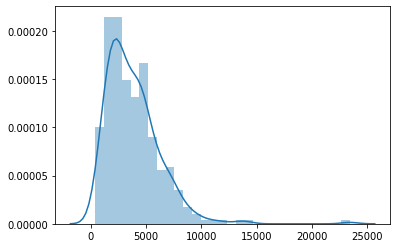

In [215]:
grafico = sb.distplot(demora_promedio_corrida)

### Calcule el porcentaje de tiempo de ocupación de cada caja.

In [216]:
ocupacion_caja1 = 0
ocupacion_caja2 = 0
i = 0
resultado = {}

for key, value in ocupacion_cajas.items():
    i+=1
    ocupacion_caja1 = ocupacion_caja1 + value['caja1']
    ocupacion_caja2 = ocupacion_caja2 + value['caja2']

resultado[0] = str(round((ocupacion_caja1/i),2))+"%"
resultado[1] = str(round((ocupacion_caja2/i),2))+"%"
print("Ocupacion Cajas:")
print(resultado)

Ocupacion Cajas:
{0: '0.45%', 1: '0.54%'}


### Realice la simulación pero esta vez, añadiendo una nueva caja cuyo cajero tenga una capacidad de atención Normal (media = 14 min., desvío = 6 min.) y analice los resultados. ¿Los clientes pasan menos tiempo a la espera de ser atendidos?

In [217]:
demora_promedio_corrida, ocupacion_cajas = simulacion(cant_experimentos=1, cant_corridas=365,cant_clientes=10,cant_cajas=3)

### Resultado con una 3er caja agregada

In [218]:
print(f"Demora promedio {np.mean(demora_promedio_corrida):.2f}")

Demora promedio 618.30


Este resultado me indica que el promedio de espera de los clientes se reduce cuando agrego una caja mas a la simulacion.

### Calcule la cantidad necesaria de cajas y sus características de atención, para disminuir el tiempo de espera de los clientes en un 25%.

Tomando en cuenta que el tiempo de espera de los clientes en promedio es de 3748.64 reducirlo en un 25% implicaria 
que el promedio de espera queda en un valor aproximado de 2811.48. Realizando una regla de 3 si con 2 maquinas obtengo
un promedio de 3748.64 entonces necesitaria aproximadamente 1.5 maquinas mas ~= 2 maquinas.